If you are using VSCode, simply clone the repository in a container volume. Otherwise, you'll need standard Anaconda packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Helper functions for later

In [2]:
def get_dispatch(market, intercept, slope):
    dispatch =  np.maximum(
        np.minimum(
            intercept + slope*market.Bid - market.Capacity.cumsum().shift(fill_value=0),
            market.Capacity
        ),
        0
    )
    return dispatch

def visualize(market, intercept, slope, ax):
    ax.step(market.Capacity.cumsum(), market.Bid)
    ax.plot([intercept + slope*market.Bid.max(), intercept], [market.Bid.max(), 0])
    dispatched = market.loc[market.Dispatch > 0].iloc[-1]
    ax.hlines(
        dispatched['Total Marginal Cost'] + dispatched.Surplus/dispatched.Dispatch,
        ax.get_xlim()[0], ax.get_xlim()[1],
        color='black',
        linestyle='dashed'
    )
    print(dispatched['Total Marginal Cost'] + dispatched.Surplus/dispatched.Dispatch)
    ax.grid()

Load and process portfolio data

In [3]:
portfolios = pd.read_excel('ESG Portfolios.xlsx')
portfolios.columns = portfolios.iloc[0:3].bfill().iloc[0]
portfolios = portfolios.iloc[3:]
portfolios = portfolios[portfolios['UNIT NAME'] != 'Totals']
portfolios.dropna(axis='index', how='all', inplace=True)
portfolios.dropna(axis='columns', how='all', inplace=True)
portfolios['portfolio'] = (portfolios.isna().any(axis='columns') * portfolios['UNIT NAME']).replace('', np.NaN).ffill()
portfolios.dropna(axis='index', how='any', inplace=True)
portfolios.set_index(['Location', 'portfolio', 'UNIT NAME'], inplace=True)
portfolios.sort_index(axis='index',level=['Location', 'portfolio'], inplace=True)

Load and process profile data

In [4]:
profiles = pd.read_excel('ESG Demand Year 2 - Day 4 Update.xlsx', header=2, index_col=[1,0,2])
profiles['Load Intercept'] = (profiles['Load Intercept with EVs'] - profiles['Renewables Forecast']).fillna(profiles['Load Intercept'])
profiles.drop(columns=['Load Intercept with EVs', 'Renewables Forecast'], inplace=True)
profiles.dropna(axis='index', how='any', inplace=True)
profiles.sort_index(inplace=True)

``simulate`` accepts an hour and a bid, both of which are pandas ``Series`` objects with indices taken from the ``portfolios`` and ``profiles`` objects, respectively. It returns a copy of ``portfolios`` with dispatch and surplus results.

In [5]:
def simulate_hour(hour, bid, pay_as_bid, transmission_capacity, co2_tax):

    results = portfolios.copy()
    results['Bid'] = bid
    results.sort_values('Bid', inplace=True)
    results['Dispatch'] = get_dispatch(results, hour.sum()['Load Intercept'], hour.sum()['Load Slope'])

    generation = results.Dispatch.groupby('Location').sum()
    consumption = np.linalg.inv(
        np.array(
            [
                np.array([1,-1])*np.array([1/hour.loc[location, 'Load Slope'] for location in hour.index]),
                [1, 1]
            ]
        )
    )@np.array(
        [
            np.array([1, -1])@(hour['Load Intercept']/hour['Load Slope']),
            results.Dispatch.sum()
        ]
    )
    shortage = consumption - generation

    if np.abs(shortage).mean() >= transmission_capacity:

        shortage = transmission_capacity*np.sign(shortage)
        results.Dispatch = results.groupby('Location', group_keys=False).apply(
            lambda market: get_dispatch(
                market, hour.loc[market.name, 'Load Intercept'] 
                - shortage[market.name], hour.loc[market.name, 'Load Slope']
            )
        )
        generation = results.Dispatch.groupby('Location').sum()
        consumption = generation + shortage

    price = (consumption - hour['Load Intercept'])/hour['Load Slope']

    results['Surplus'] = results.groupby('Location', group_keys=False).apply(
        lambda market: market.Dispatch*(
            (market.Bid if pay_as_bid else price[market.name]) - market['Total Marginal Cost']
        ) 
    )

    results['Profit'] = results.groupby('Location', group_keys=False).apply(
        lambda market: market.Surplus
        - market.Dispatch*co2_tax*market.CO2
        - market['O&M/Day ($)']/4
    )
    return results

A wrapper function to simulate a full year given a bid profile

In [6]:
def simulate(bids):
    return profiles.groupby(['Day', 'Hour']).apply(
        lambda hour: simulate_hour(
            hour = hour.droplevel(['Day', 'Hour']), 
            bid = bids[hour.name],
            pay_as_bid = hour.name[0] == 1,
            transmission_capacity = 500 if hour.name[0] == 2 else 10000,
            co2_tax = 50*(hour.name[0] == 3)
        )
    )

As a baseline, bid marginal cost every hour.

In [7]:
bids = pd.DataFrame(
    {
        (day, hour): portfolios['Total Marginal Cost'] 
        + portfolios.CO2*50*(day == 3)
        for (day, hour) in profiles.index.droplevel('Location')
        }
)
bids.columns.rename(profiles.index.droplevel('Location').names, inplace=True)

To run a scenario, modify ``bids`` and then run ``simulate(bids)``. ``bids`` has the following format, which must be kept the same - only modify the values!

In [8]:
results = simulate(bids)

For the first hour, each generator with marginal cost less than the clearing price bids the clearing price (minus one cent). The resulting profit values are the results in the competitive case, which are a lower bound on our expected profits.

In [9]:
prices = results.loc[1].groupby('Hour').apply(
    lambda market: market[market.Dispatch > 0].iloc[-1]
)
prices = prices['Total Marginal Cost'] + prices.Surplus/prices.Dispatch
bids[1] = bids[1].apply(lambda row: np.maximum(row, prices-.01), axis='columns')

profiles.loc[(['North', 'South'], 1), 'Load Intercept'] *= 1.09/.97
results = simulate(bids)

In [10]:
day = 4
hour = 4

# Uncomment to run heuristic market power algorithm
# equilibrium = False
# while not equilibrium:
#     market = results.loc[day,hour]
#     price_setter = market[market.Dispatch > 0].iloc[-1]
#     new_bids = bids.copy()
#     new_bids.loc[price_setter.name,(day,hour)] = 500
#     new_results = simulate(new_bids)
#     if new_results.loc[day,hour,price_setter.name[0],price_setter.name[1]].Surplus.sum() >= market.loc[price_setter.name[0],price_setter.name[1]].Surplus.sum():
#         bids = new_bids
#         results = new_results
#         print(price_setter.name)
#     else:
#         equilibrium = True

# results = simulate(bids)

75.88888888888853


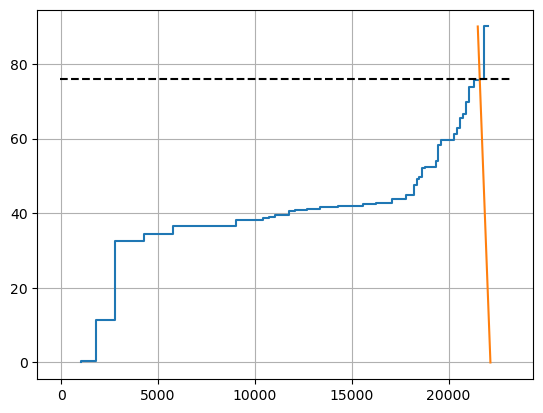

In [11]:
fig, ax = plt.subplots()
hour_results = results.loc[day, hour]
(intercept, slope) = profiles.loc[(['North', 'South'], day, hour)].sum()
visualize(hour_results, intercept, slope, ax)
fig.show()